In [38]:
import json
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [39]:
with open('results.json', 'r') as file:
    data = json.load(file)

records = []
detailed_metrics = {}   # key is {num_classes}_{model}_{db_mod}_{test_mod}

for config_key, config_data in data.items():
    infos = config_key.split("_")
    num_classes, db_images, test_images, model = infos[0], infos[1], infos[2], infos[3]
    next_id = 4
    
    if infos[next_id] == "clean":
        db_mod = "clean"
        next_id += 1
    else:
        db_mod = infos[next_id]
        next_id += 1
        if db_mod == "fawkes":
            db_mod += f" ({infos[next_id]})"
        next_id += 1
    if infos[next_id] == "clean":
        test_mod = "clean"
        next_id += 1
    else:
        test_mod = infos[next_id]
        next_id += 1
        if test_mod == "fawkes":
            test_mod += f" ({infos[next_id]})"
        next_id += 1
    
    eer = config_data["EER"]
    acc_at_eer = config_data["Accuracy at EER"]
    eer_thresh = config_data["EER Threshold"]

    metrics_key = f"{int(num_classes)}_{model}_{db_mod}_{test_mod}"
    detailed_metrics[metrics_key] = {
        "EER": eer,
        "Accuracy at EER": acc_at_eer,
        "EER Threshold": eer_thresh,
        "Thresholds": config_data["Thresholds"],
        "Accuracies": config_data["Accuracies"],
        "FARs": config_data["FARs"],
        "FRRs": config_data["FRRs"],
        "Misclassifications": config_data["Misclassifications"]
    }

    records.append({
        "Num Classes": int(num_classes),
        "Model": model,
        "Database Mod": db_mod,
        "Test Mod": test_mod,
        "EER": eer,
        "Accuracy at EER": acc_at_eer,
    })

df = pd.DataFrame(records)
df['Test Mod'] = df['Test Mod'].replace('clean', 'none')
df['Database Mod'] = df['Database Mod'].replace('clean', 'none')

In [40]:
class_numbers_list = [10, 50, 100]
models_list = ["Facenet", "ArcFace", "GhostFaceNet"]
model_colors = {
    "Facenet": "#1f77b4",
    "ArcFace": "#ff7f0e",
    "GhostFaceNet": "#2ca02c",
}

In [41]:
face_df = {}
for class_number in class_numbers_list:
    face_df[class_number] = df[df["Num Classes"] == class_number]

face_df_display = {}
columns_to_display = ["Database Mod", "Test Mod", "EER", "Accuracy at EER"]

for class_number in class_numbers_list:
    face_df_display[class_number] = {}
    for model_name in models_list:
        model_df = df[(df["Num Classes"] == class_number) & (df["Model"] == model_name)][columns_to_display]
        face_df_display[class_number][model_name] = model_df.to_html(index=False)

for class_number in class_numbers_list:
    display(HTML(
        '<div style="display: flex; justify-content: space-around;">'
        f'<div style="padding: 10px;"><h4>Facenet {class_number} Classes</h4>{face_df_display[class_number]["Facenet"]}</div>'
        f'<div style="padding: 10px;"><h4>ArcFace {class_number} Classes</h4>{face_df_display[class_number]["ArcFace"]}</div>'
        f'<div style="padding: 10px;"><h4>GhostFaceNet {class_number} Classes</h4>{face_df_display[class_number]["GhostFaceNet"]}</div>'
        '</div>'
    ))


Database Mod,Test Mod,EER,Accuracy at EER
none,none,0.040,0.957
none,blur,0.190,0.760
none,permute,0.455,0.308
none,fawkes (low),0.092,0.897
none,fawkes (mid),0.208,0.743
none,fawkes (high),0.260,0.673
none,lowkey,0.365,0.493
none,style,0.253,0.640
blur,none,0.145,0.832
blur,blur,0.182,0.772


Database Mod,Test Mod,EER,Accuracy at EER
none,none,0.046,0.952
none,blur,0.212,0.747
none,permute,0.526,0.237
none,fawkes (low),0.115,0.874
none,fawkes (mid),0.270,0.663
none,fawkes (high),0.322,0.565
none,lowkey,0.444,0.383
none,style,0.347,0.517
blur,none,0.132,0.858
blur,blur,0.220,0.726


Database Mod,Test Mod,EER,Accuracy at EER
none,none,0.061,0.937
none,blur,0.275,0.674
none,permute,0.497,0.252
none,fawkes (low),0.150,0.834
none,fawkes (mid),0.324,0.590
none,fawkes (high),0.391,0.485
none,lowkey,0.456,0.348
none,style,0.418,0.429
blur,none,0.166,0.813
blur,blur,0.260,0.672


In [45]:
def plot_model_performance(metrics, num_classes, model, db_mod, test_mod):
    config_key = f"{num_classes}_{model}_{db_mod}_{test_mod}"
    data = metrics[config_key]

    plt.figure(figsize=(10, 5))
    plt.axvline(x=data["EER Threshold"], label='EER Threshold', color='black', linestyle='--')
    plt.plot(data["Thresholds"], data["Accuracies"], label="Accuracy", color="darkgray")
    plt.plot(data["Thresholds"], data["FARs"], label="FAR", color="darkblue")
    plt.plot(data["Thresholds"], data["FRRs"], label="FRR", color="darkred")
    # plt.title(f"Model: {model}      Database: {db_mod}      Test Set: {test_mod}")
    plt.xlabel("Threshold")
    plt.ylabel("Metric Value")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

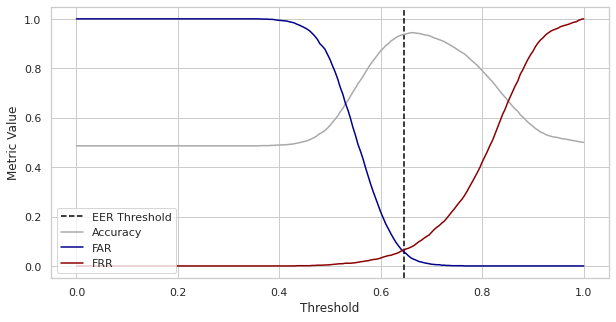

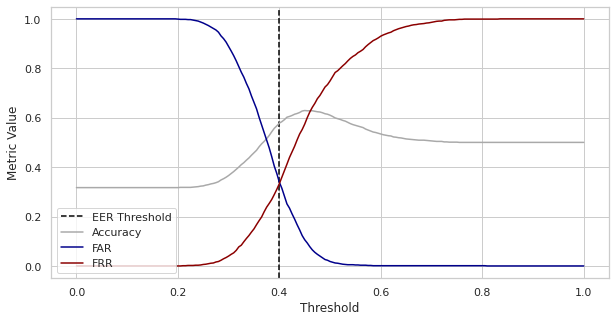

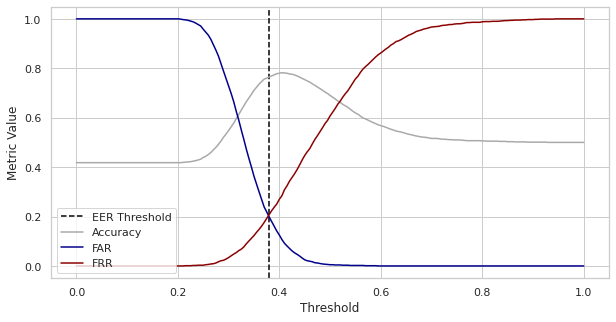

In [43]:
plot_model_performance(detailed_metrics, 100, "Facenet", "clean", "clean")
plot_model_performance(detailed_metrics, 100, "ArcFace", "fawkes (high)", "clean")
plot_model_performance(detailed_metrics, 100, "GhostFaceNet", "fawkes (mid)", "fawkes (mid)")

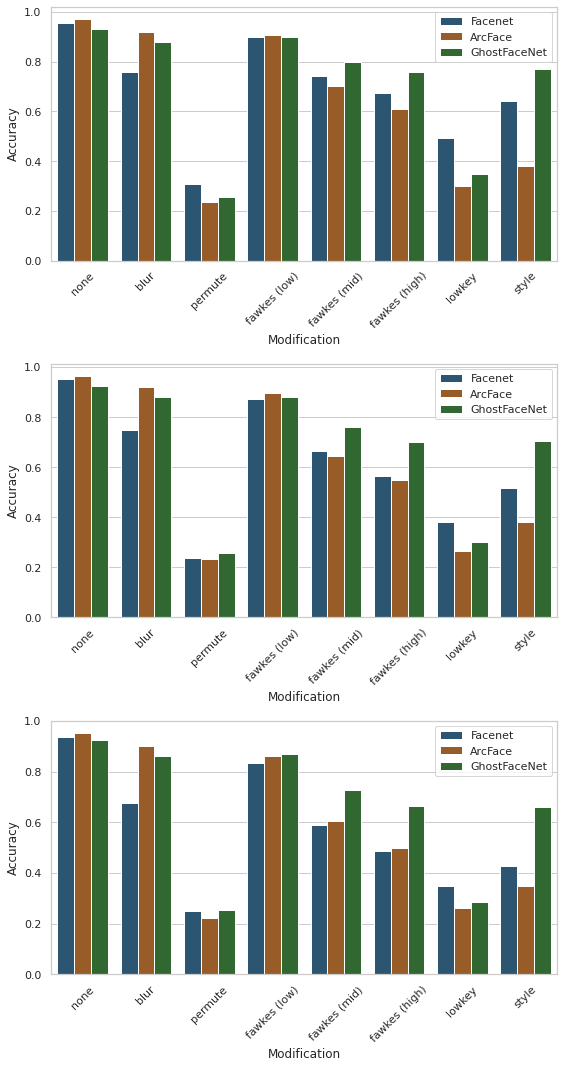

In [52]:
num_classes = len(class_numbers_list)

fig, axes = plt.subplots(num_classes, 1, figsize=(8, 5 * num_classes), squeeze=False)
axes_flat = axes.flatten()

palette = {}
for model in models_list:
    palette[model] = sns.dark_palette(model_colors[model])[3]

for i, class_number in enumerate(class_numbers_list):
    modified_on_clean_df = df[(df['Num Classes'] == class_number) & (df['Database Mod'] == 'none')]

    ax = axes_flat[i]
    barplot = sns.barplot(data=modified_on_clean_df, x='Test Mod', y='Accuracy at EER', hue='Model', palette=palette, ax=ax)
    # ax.set_title(f'Accuracy of Modified Images on Clean Database for {class_number} Classes')
    ax.set_xlabel('Modification')
    ax.set_ylabel('Accuracy')
    ax.legend()

    barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

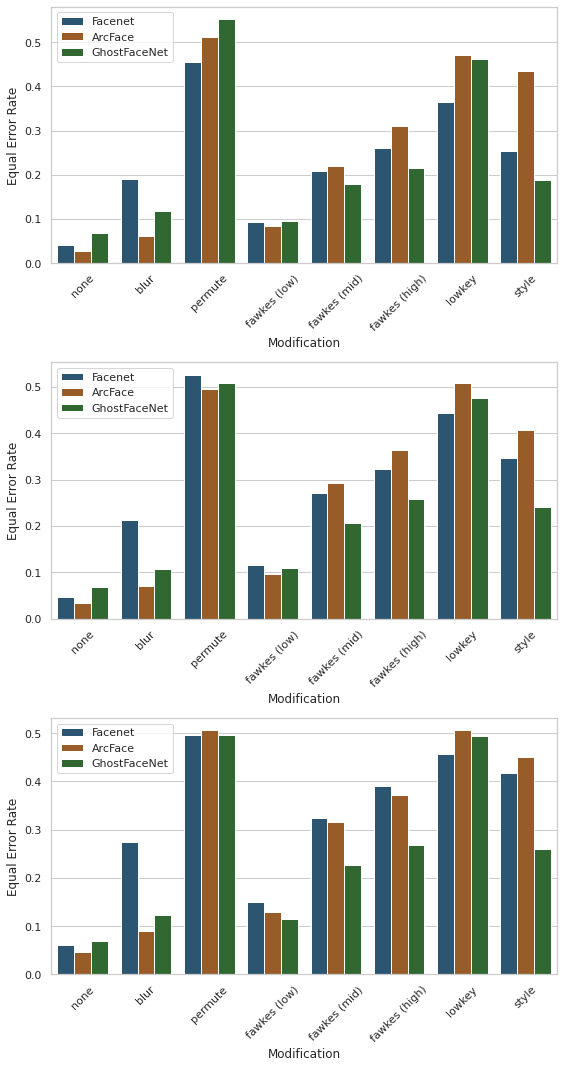

In [56]:
num_classes = len(class_numbers_list)

fig, axes = plt.subplots(num_classes, 1, figsize=(8, 5 * num_classes), squeeze=False)
axes_flat = axes.flatten()

palette = {}
for model in models_list:
    palette[model] = sns.dark_palette(model_colors[model])[3]

for i, class_number in enumerate(class_numbers_list):
    modified_on_clean_df = df[(df['Num Classes'] == class_number) & (df['Database Mod'] == 'none')]

    ax = axes_flat[i]
    barplot = sns.barplot(data=modified_on_clean_df, x='Test Mod', y='EER', hue='Model', palette=palette, ax=ax)
    # ax.set_title(f'EER of Modified Images on Clean Database for {class_number} Classes')
    ax.set_xlabel('Modification')
    ax.set_ylabel('Equal Error Rate')
    ax.legend()

    barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

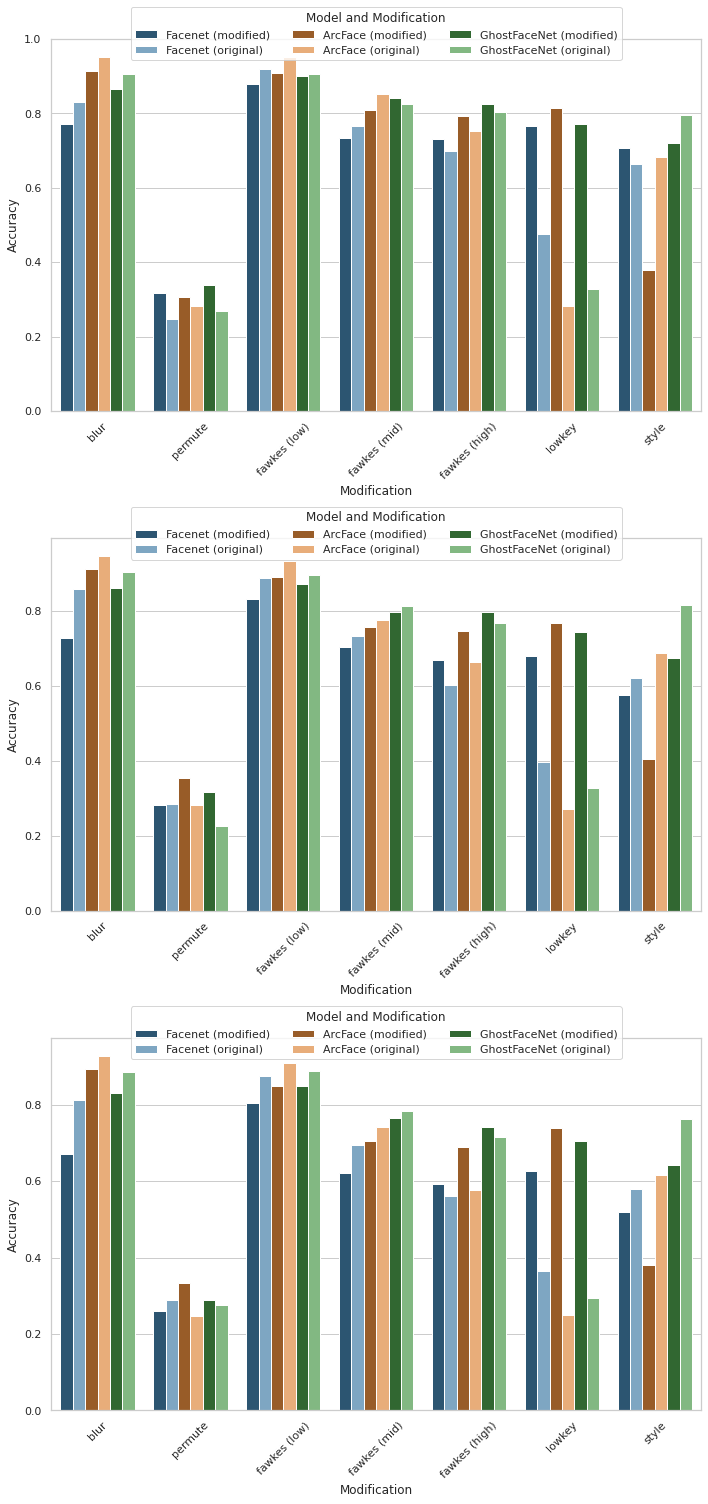

In [60]:
mod_acc_df = df[(df['Database Mod'] == df['Test Mod'])].copy()
mod_acc_df['Image Type'] = 'Modified'
clean_acc_df = df[(df['Database Mod'] != 'none') & (df['Test Mod'] == 'none')].copy()
clean_acc_df['Image Type'] = 'Clean'
combined_df = pd.concat([mod_acc_df, clean_acc_df], ignore_index=True)

fig, axes = plt.subplots(len(class_numbers_list), 1, figsize=(10, 7 * len(class_numbers_list)), squeeze=False)
axes_flat = axes.flatten()

modification_order = combined_df['Database Mod'].unique()

palette = {}
for model in models_list:
    palette[f"{model}_Modified"] = sns.dark_palette(model_colors[model])[3]
    palette[f"{model}_Clean"] = sns.light_palette(model_colors[model])[3]


for i, class_number in enumerate(class_numbers_list):
    ax = axes_flat[i]

    plot_df = combined_df[combined_df['Num Classes'] == class_number]
    plot_df = plot_df[plot_df['Database Mod'] != 'none']

    hue_order = [f"{model}_{img_type}" for model in models_list for img_type in ['Modified', 'Clean']]
    plot_df['Hue'] = plot_df['Model'] + '_' + plot_df['Image Type']

    sns.barplot(data=plot_df, x='Database Mod', y='Accuracy at EER', hue='Hue', 
                palette=palette, ax=ax, hue_order=hue_order)

    # ax.set_title(f'Accuracy of Models on Modified Database for {class_number} Classes')
    ax.set_xlabel('Modification')
    ax.set_ylabel('Accuracy')
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    # ax.legend(title='Model and Modification', bbox_to_anchor=(1.05, 1), loc='upper left')
    # ax.legend(title='Model and Modification', bbox_to_anchor=(0.78, 0.76), loc='lower left')
    legend = ax.legend(title='Model and Modification', bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=len(models_list))
    
    custom_labels = [f"{model} ({'modified' if img_type == 'Modified' else 'original'})" for model in models_list for img_type in ['Modified', 'Clean']]
    for t, label in zip(legend.texts, custom_labels):
        t.set_text(label)

plt.tight_layout()
plt.show()

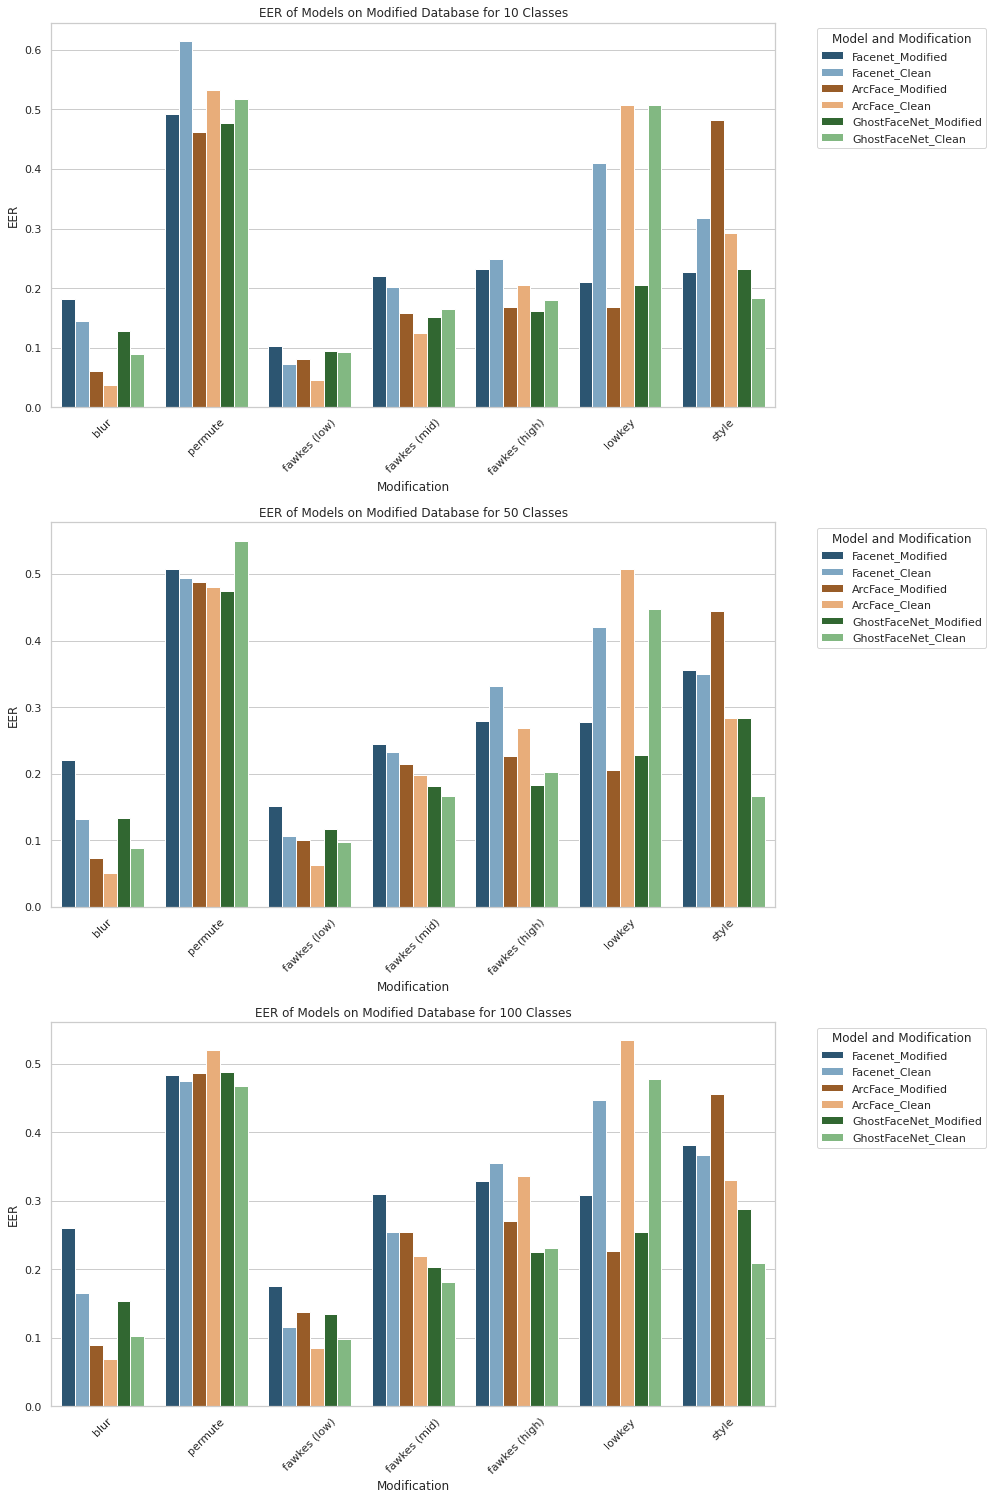

In [49]:
mod_acc_df = df[(df['Database Mod'] == df['Test Mod'])].copy()
mod_acc_df['Image Type'] = 'Modified'
clean_acc_df = df[(df['Database Mod'] != 'none') & (df['Test Mod'] == 'none')].copy()
clean_acc_df['Image Type'] = 'Clean'
combined_df = pd.concat([mod_acc_df, clean_acc_df], ignore_index=True)

fig, axes = plt.subplots(len(class_numbers_list), 1, figsize=(14, 7 * len(class_numbers_list)), squeeze=False)
axes_flat = axes.flatten()

modification_order = combined_df['Database Mod'].unique()

palette = {}
for model in models_list:
    palette[f"{model}_Modified"] = sns.dark_palette(model_colors[model])[3]
    palette[f"{model}_Clean"] = sns.light_palette(model_colors[model])[3]


for i, class_number in enumerate(class_numbers_list):
    ax = axes_flat[i]

    plot_df = combined_df[combined_df['Num Classes'] == class_number]
    plot_df = plot_df[plot_df['Database Mod'] != 'none']

    hue_order = [f"{model}_{img_type}" for model in models_list for img_type in ['Modified', 'Clean']]
    plot_df['Hue'] = plot_df['Model'] + '_' + plot_df['Image Type']

    sns.barplot(data=plot_df, x='Database Mod', y='EER', hue='Hue', 
                palette=palette, ax=ax, hue_order=hue_order)

    ax.set_title(f'EER of Models on Modified Database for {class_number} Classes')
    ax.set_xlabel('Modification')
    ax.set_ylabel('EER')
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.legend(title='Model and Modification', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()